# Face recognition

Face recognition concernes the identifing or verifying a person's identity from a visual input like an image or a video frame. It can be formulated as a classification problem, where the inputs are the images and the outputs are the identities or the names of the people.
This notebook analyses three different techniques for feature extraction in the context of face recognition:
    1. PCA (Principal Components Analysis)
    2. LDA (Linear Discirminant Analysis)
    3. LBP (Local Binary Patterns)
using three different datasets:
    1. AT&T Faces dataset
    2. Labeled faces of the wild
    3. Caltech Faces dataset
  

In [2]:
# local packages
from localmodules.datasets import load_faces
from localmodules.distance import L2_distance, KLD, CHI2, show_pair
from localmodules.local_binary_patterns import LBP

# sklearn packages
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, auc, precision_recall_curve, average_precision_score

import numpy as np
import cv2
import operator

import matplotlib.pyplot as plt

from utils import *
from constants import *
from evaluation_utils import *

In [3]:
def get_faces(facesDB):
    if facesDB == "ATT":
        faces = load_faces("ATT", dataset = None, min_faces=10, max_targets=MAX_PERSONS)
    elif facesDB == "LFW": 
        faces = load_faces("LFW", dataset = None, min_faces=10, max_targets=MAX_PERSONS)
    elif facesDB == "CALTECH":
        faces = load_faces("CALTECH", dataset = CALTECH_DB_PATH, min_faces=10, max_targets=MAX_PERSONS)
    
    return faces

### Definition of necessary methods for the flow of the system

In [6]:
def perform_method(DESC, faces):
    # select the feature embedding mehtod (PCA, LDA, LBP)
    # returns the vector-coded embedding of the images
    X = StandardScaler().fit_transform(faces.data) # standardization
    y = faces.target
    n_samples, h, w = faces.images.shape  
    n_features = faces.data.shape[1]
    if DESC == "PCA":
        # Compute a PCA (eigenfaces) on the face dataset
        pca_components = min(NUM_COMPONENTS, min(n_samples, n_features))
        print("Number of components {n}".format(n=pca_components))
        pca = PCA(n_components=pca_components, svd_solver='randomized', whiten=True)
        desc = pca.fit(X)
        print('Explained variance {}'.format(desc.explained_variance_ratio_))
        X_pca = desc.transform(X)  # Apply dimensionality reduction to X
        embedded = X_pca

    elif DESC == "LDA":
        lda_components = min(NUM_COMPONENTS, min(n_samples, n_features))
        print("Number of components {n}".format(n=lda_components))
        desc = LinearDiscriminantAnalysis(n_components=lda_components).fit(X, y)
        X_lda = desc.fit_transform(X, y)
        embedded = X_lda

    elif DESC == "LBP":
        desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
        embedded = desc.describe_list(faces.images)
        
    return embedded

In [7]:
def calculate_distances(DESC, embedded, faces):
    distances = [] # distance between pairs
    identical = [] # 1 if same identity, 0 otherwise
    n_samples, h, w = faces.images.shape  
    targets = faces.target

    I = np.zeros((n_samples, n_samples)) 

    for i in range(n_samples-1):
        for j in range(1, n_samples):
            if DESC == "LBP":
                # Kullback-Leibler Divergence for normalized histograms
                # distances.append(KLD(embedded[i], embedded[j]))
                # Better even: Chi-square distance
                distances.append(CHI2(embedded[i], embedded[j]))
            else:
                # Euclidean norm as distance
                distances.append(L2_distance(embedded[i], embedded[j]))
            if targets[i] == targets[j]:
                identical.append(1)
                I[i,j] = I[j,i] = 1
            else:
                identical.append(0)

    distances = np.array(distances)
    # convert to normalized [0,1] score (the higher the better)
    scores = (distances.max() - distances)/distances.max()
    identical = np.array(identical)
    return I, scores, identical

In [8]:
def generate_genuine_impostor_pair(I, embedded, faces):
    genuine = np.asarray(np.where(I == 1)).T
    genuine_pair_id = np.random.randint(genuine.shape[0])

    impostor = np.asarray(np.where(I == 0)).T
    impostor_pair_id = np.random.randint(impostor.shape[0])

    show_pair(faces, embedded, genuine[genuine_pair_id][0], genuine[genuine_pair_id][1])
    show_pair(faces, embedded, impostor[impostor_pair_id][0], impostor[impostor_pair_id][1])

In [9]:
def get_true_pred_labels(all_scores, identical, dist_threshold):
    '''
    If the score i.e. the distance between two pairs is greater or equal
    to some predefined threshold, then we predict that the pair is genuine,
    otherwise it is impostor.
    Higher threshold means less flexible system, meaning that less pairs will
    be labeled as genuine. This usually makes the system highly secure.
    '''
    pred_y = []
    true_y = identical  # ground truth
    for i in range(0, len(all_scores)):        
        if all_scores[i] >= dist_threshold:  
            pred_y.append(1) 
        else: 
            pred_y.append(0)
    
    return true_y, pred_y

In [10]:
def get_geuine_impostor_scores(all_scores, identical):
    '''
    Returns two arrays with the geuine and impostor scores. 
    The genuine match scores are obtained by matching feature sets 
    of the same class (same person) and the impostor match scores are obtained 
    by matching feature sets of different classes (different persons)
    '''
    genuine_scores = []
    impostor_scores = []
    for i in range(0, len(all_scores)):        
        if identical[i] == 1: 
            genuine_scores.append(all_scores[i])
        else: 
            impostor_scores.append(all_scores[i])
    
    return genuine_scores, impostor_scores

In [12]:
def get_acc_f1_for_threshold(all_scores, identical, dist_threshold):
    '''
    Computes predicted labels for the given match scores / distances, to some
    threshold, and then computes the accuracy and f1 score
    '''
    true_y, pred_y = get_true_pred_labels(all_scores, identical, dist_threshold)
    acc = accuracy_score(true_y, pred_y)
    f1 = f1_score(true_y, pred_y)
    print('Accuracy with threshold = {}, is = {}'.format(round(dist_threshold, 2), round(acc,4)))
    print('F1 score with threshold = {}, is = {}'.format(round(dist_threshold, 2), round(f1, 4)))
    
    return acc, f1


In [13]:
def get_accuracy_f1_scores(all_scores, identical, thresholds):
    '''
    Accumulates all accuracy and f1 scores for given thresholds
    and finds the optimal threshold (the one with highest both accuracy and f1)
    '''
    accuracy_scores = []
    f1_scores = []
    optimal_threshold = 0
    best_acc = 0
    best_f1 = 0
    for dist_threshold in thresholds:
        acc, f1 = get_acc_f1_for_threshold(all_scores, identical, dist_threshold)
        if best_acc < acc and best_f1 < f1:
            optimal_threshold = dist_threshold
            best_acc = acc
            best_f1 = f1
        accuracy_scores.append(acc)
        f1_scores.append(f1)
        
    print('Optimal threshold = {}'.format(optimal_threshold))
    return accuracy_scores, f1_scores, optimal_threshold

In [15]:
def get_tp_fp_rates(all_scores, identical, thresholds): 
    '''
    Calculates the true positive and false positive rates, from the confusion matrix,
    according to some thresholded matching scores
    '''
    true_pos_rates = []
    false_pos_rates = []
    for dist_threshold in thresholds:
        true_y, pred_y = get_true_pred_labels(all_scores, identical, dist_threshold)
        tn, fp, fn, tp = confusion_matrix(true_y, pred_y).ravel()
        true_pos_rate, false_pos_rate = calculate_ratios(tp, fp, fn, tn)
        true_pos_rates.append(true_pos_rate)
        false_pos_rates.append(false_pos_rate)
        
    return true_pos_rates, false_pos_rates
    

In [16]:
def get_equal_error_rate(tpr, fpr):
    frr = 1 - np.asarray(tpr)
    min_diff = 1
    i_min = 0
    j_min = 0
    for i in range(0, len(frr)):
        for j in range(0, len(fpr)):
            diff = np.abs(frr[i] - fpr[j])
            if diff < min_diff and diff < 0.2:
                min_diff = diff
                i_min = i
                j_min = j
    
    return np.min([frr[i_min], fpr[j_min]])

The following method summarizes all methods defined above, for a specified features extraction technique.

In [17]:
def perform_all_steps(DESC, faces, embedded):
    print('--- Choosed technique: {}'.format(DESC))
    print('1. Calculating feature descriptors')
    n_samples, h, w = faces.images.shape
    
    print('2. Calculating pair-wise matching scores (i.e. distances between pairs)')
    I, scores, identical = calculate_distances(DESC, embedded, faces)
    
    print('3. Generating genuine - impostor pairs and plotting the pairs with their matching score')
    generate_genuine_impostor_pair(I, embedded, faces)
    
    genuine_scores, impostor_scores = get_geuine_impostor_scores(scores, identical)
    print('4. Generating genuine - impostor distribution')
    plot_genuine_impostor_distribution(genuine_scores, impostor_scores)
    
    print('5. Computing F1 and accuracy scores for a range of thresholds')
    thresholds = np.arange(0.40, 0.90, 0.10)
    accuracy_scores, f1_scores, optimal_threshold = get_accuracy_f1_scores(scores, identical, thresholds)
    print('6. Plotting F1 and accuracy scores ')
    plot_accuracy_f1_scores(accuracy_scores, f1_scores, thresholds)
    
    print('--- The most optimal threshold is: {}'.format(optimal_threshold))
    get_acc_f1_for_threshold(scores, identical, optimal_threshold)
    true_y, pred_y = get_true_pred_labels(scores, identical, optimal_threshold)
    
    print('7. Averaged precision score is: {}'.format(round(precision_score(true_y, pred_y, average='micro'),2)))
    true_pos_rates, false_pos_rates = get_tp_fp_rates(scores, identical, thresholds)
    print(1-np.asarray(true_pos_rates))
    print(false_pos_rates)

    print('Equal Error Rate is: {}'.format(get_equal_error_rate(true_pos_rates, false_pos_rates)))
        
    print('8. Plotting ROC curve (TPR vs FPR)')
    get_roc_curve_tpr_fpr(true_pos_rates, false_pos_rates)
    print('9. AUC score for thresholded distances is {}'.format(round(auc(false_pos_rates, true_pos_rates), 3)))

## Testing three different datasets

### AT&T Facedatabase
This dataset was collected by the AT&T Laboratories Cambridge and contains a set of face images taken between April 1992 and April 1994 at their lab. There are ten different images of each of 40 distinct subjects. [1] For sake of simplicity, we will use 10 different subjects, meaning 10 different classes.

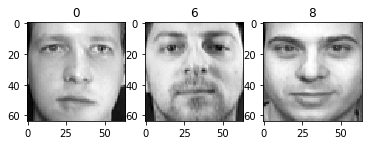

Total dataset size:
n_samples: 80
n_features: 4096
n_classes: 8


In [18]:
faces_att = get_faces("ATT")
plot_faces(faces_att)
get_data_statistics(faces_att)

## PCA
Principal Component Analysis represents a statistical approach that is well known for dimensionality reduction.
    The idea behind PCA, is to extract the relevant information from a face image, encode it as efficiently as possible and compare one query face encoding with a database of faces similarly encoded. Mathematically speaking, we wish to find the eigenvectors of the covariance matrix of the set of images. By displaying these eigenvectors, we get a ghostly representation of a face, also called eigenface. The "best" eigenfaces account for the most variance within the set of face images. [2]


Number of components 30
Explained variance [0.28043532 0.16058394 0.07768647 0.06058205 0.04789809 0.04211448
 0.03351866 0.02446912 0.01939861 0.01698533 0.01610395 0.01283193
 0.01250837 0.01154065 0.01086788 0.00911314 0.00829955 0.00767317
 0.00729964 0.00687529 0.00651936 0.00591334 0.005571   0.00544797
 0.00522833 0.00478068 0.00467713 0.00451837 0.00419099 0.00407127]
--- Choosed technique: PCA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


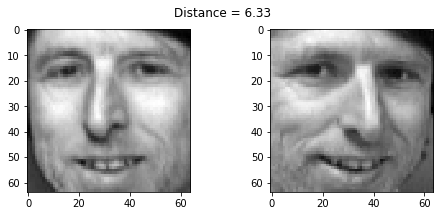

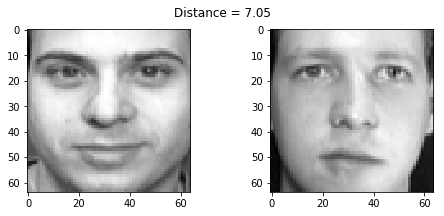

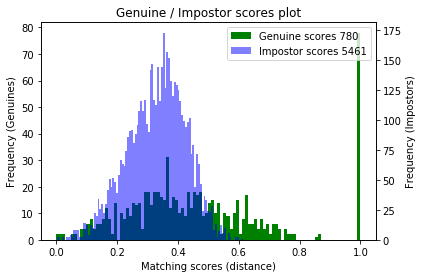

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.7268
F1 score with threshold = 0.4, is = 0.3269
Accuracy with threshold = 0.5, is = 0.8976
F1 score with threshold = 0.5, is = 0.4679
Accuracy with threshold = 0.6, is = 0.9034
F1 score with threshold = 0.6, is = 0.3712
Accuracy with threshold = 0.7, is = 0.8925
F1 score with threshold = 0.7, is = 0.2452
Accuracy with threshold = 0.8, is = 0.888
F1 score with threshold = 0.8, is = 0.1882
Optimal threshold = 0.5
6. Plotting F1 and accuracy scores 


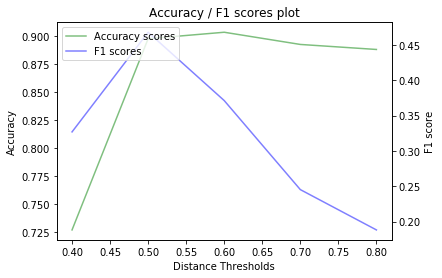

--- The most optimal threshold is: 0.5
Accuracy with threshold = 0.5, is = 0.8976
F1 score with threshold = 0.5, is = 0.4679
7. Averaged precision score is: 0.9
[0.46923077 0.63974359 0.77179487 0.86025641 0.89615385]
[0.24519318806079474, 0.025636330342428126, 0.00018311664530305805, 0.0, 0.0]
Equal Error Rate is: 0.24519318806079474
8. Plotting ROC curve (TPR vs FPR)


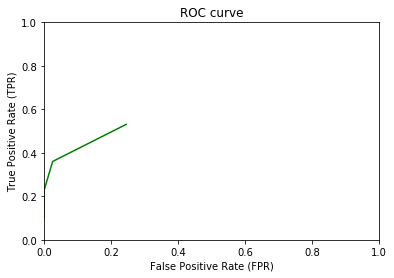

9. AUC score for thresholded distances is 0.105


In [19]:
embedded_att_pca = perform_method("PCA", faces_att)
perform_all_steps("PCA", faces_att, embedded_att_pca)

## LDA
The idea behind LDA is to find linear transformations that will maximize the discriminatory information in data.
Linear Discriminant Analysis is enhancement of Principal Component Analysis, since PCA does not use the concept of classes and LDA does. The difference between these two approaches is that PCA tries to maximize the variance of the dataset, whereas LDA maximizes the class - separation. There is research work proving that LDA outpreforms PCA when it comes to many different tasks, including face recognition. [3] The results obtained in the example below, show the same. By observing the genuine - impostor distribution, it can be concluded that there is better sepparation and the intersect is very small compared to the one obtained by PCA. Moreover, the accuracy is 0.98 and the F1 score is 0.94, which adds to the good performance of LDA. 

Number of components 30


/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


--- Choosed technique: LDA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


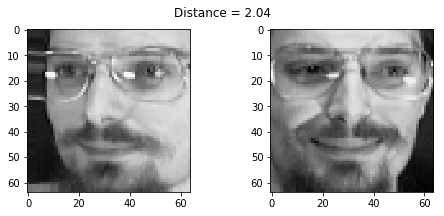

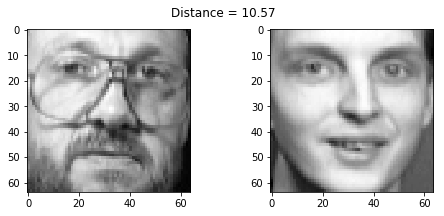

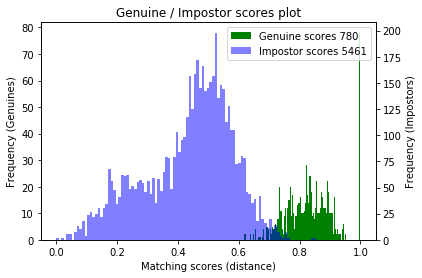

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.4156
F1 score with threshold = 0.4, is = 0.2996
Accuracy with threshold = 0.5, is = 0.6616
F1 score with threshold = 0.5, is = 0.4248
Accuracy with threshold = 0.6, is = 0.9122
F1 score with threshold = 0.6, is = 0.74
Accuracy with threshold = 0.7, is = 0.9846
F1 score with threshold = 0.7, is = 0.9401
Accuracy with threshold = 0.8, is = 0.9579
F1 score with threshold = 0.8, is = 0.7985
Optimal threshold = 0.7
6. Plotting F1 and accuracy scores 


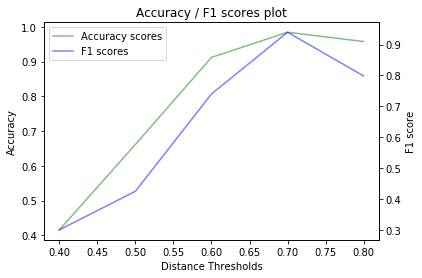

--- The most optimal threshold is: 0.7
Accuracy with threshold = 0.7, is = 0.9846
F1 score with threshold = 0.7, is = 0.9401
7. Averaged precision score is: 0.98
[0.         0.         0.         0.03333333 0.33205128]
[0.6678264054202527, 0.3867423548800586, 0.10034792162607581, 0.012818165171214063, 0.0007324665812122322]
Equal Error Rate is: 0.0
8. Plotting ROC curve (TPR vs FPR)


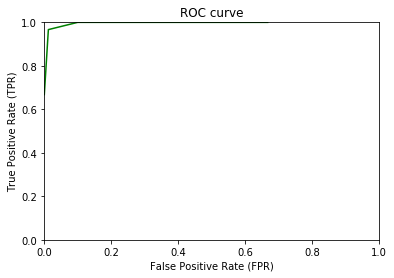

9. AUC score for thresholded distances is 0.663


In [20]:
embedded_att_lda = perform_method("LDA", faces_att)
perform_all_steps("LDA", faces_att, embedded_att_lda)

## LBP
Local Binary Patterns are described as texture descriptors, which label the pixels of the image by thresholding the neighborhood of each pixel and set the result as a binary number. This makes LBP quite different approach compared to PCA and LDA. The genuine - impostor plot shows that LBP performs better compared to PCA, but it seems that LDA still shows a bit better results.

--- Choosed technique: LBP
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


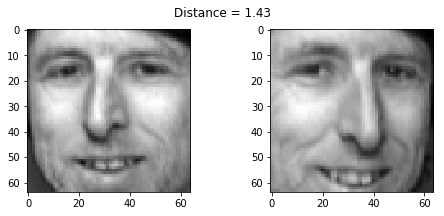

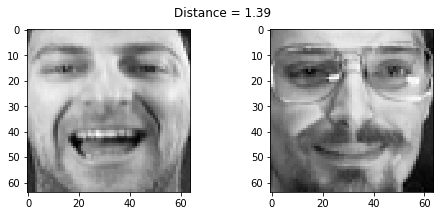

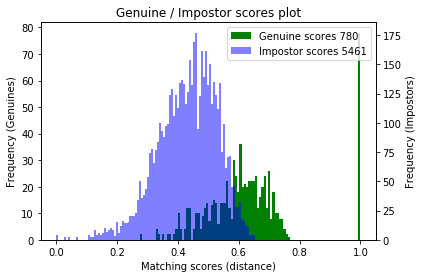

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.4246
F1 score with threshold = 0.4, is = 0.2974
Accuracy with threshold = 0.5, is = 0.7488
F1 score with threshold = 0.5, is = 0.4559
Accuracy with threshold = 0.6, is = 0.9314
F1 score with threshold = 0.6, is = 0.6796
Accuracy with threshold = 0.7, is = 0.9005
F1 score with threshold = 0.7, is = 0.3387
Accuracy with threshold = 0.8, is = 0.8875
F1 score with threshold = 0.8, is = 0.1818
Optimal threshold = 0.6
6. Plotting F1 and accuracy scores 


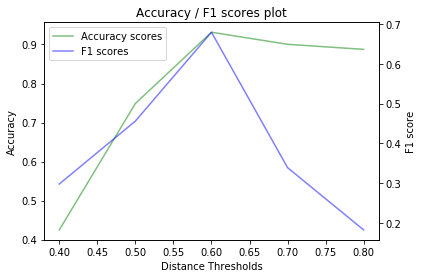

--- The most optimal threshold is: 0.6
Accuracy with threshold = 0.6, is = 0.9314
F1 score with threshold = 0.6, is = 0.6796
7. Averaged precision score is: 0.93
[0.02564103 0.15769231 0.41794872 0.79615385 0.9       ]
[0.6539095403772203, 0.2646035524629189, 0.01867789782091192, 0.0, 0.0]
Equal Error Rate is: 0.01867789782091192
8. Plotting ROC curve (TPR vs FPR)


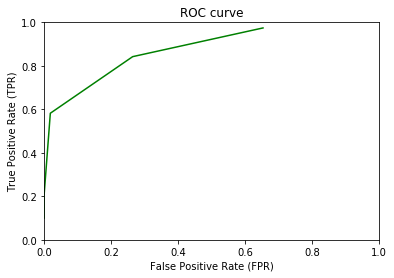

9. AUC score for thresholded distances is 0.536


In [21]:
embedded_att_lbp = perform_method("LBP", faces_att)
perform_all_steps("LBP", faces_att, embedded_att_lbp)

### Labeled Faces of the Wild

We repeat the above steps with the three different approaches, for the LFW dataset.

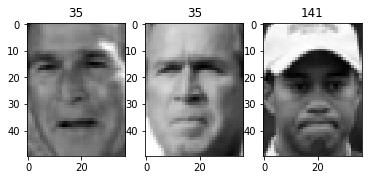

Total dataset size:
n_samples: 756
n_features: 1850
n_classes: 10


In [22]:
faces_lfw = get_faces("LFW")
plot_faces(faces_lfw)
get_data_statistics(faces_lfw)

Number of components 30
Explained variance [0.24199429 0.16072679 0.07156521 0.05810875 0.03158488 0.02901821
 0.02243957 0.02119108 0.0185903  0.01695668 0.01526446 0.01363839
 0.01273277 0.01027253 0.00895132 0.00872525 0.00824663 0.00759438
 0.0070332  0.00616261 0.00577295 0.00556871 0.00525597 0.00510014
 0.00492226 0.00483979 0.00462901 0.0044132  0.00420123 0.00400491]
--- Choosed technique: PCA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


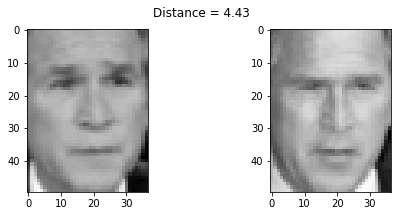

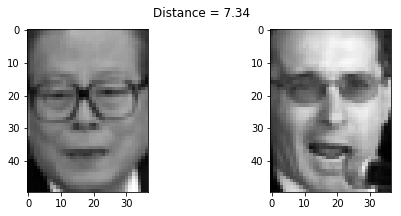

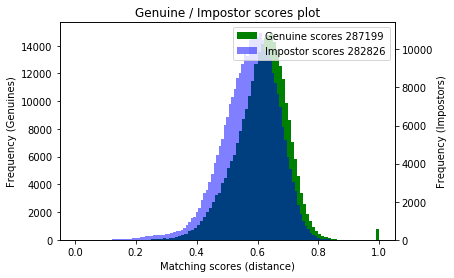

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.5157
F1 score with threshold = 0.4, is = 0.6723
Accuracy with threshold = 0.5, is = 0.546
F1 score with threshold = 0.5, is = 0.6652
Accuracy with threshold = 0.6, is = 0.5878
F1 score with threshold = 0.6, is = 0.595
Accuracy with threshold = 0.7, is = 0.5319
F1 score with threshold = 0.7, is = 0.2248
Accuracy with threshold = 0.8, is = 0.4991
F1 score with threshold = 0.8, is = 0.013
Optimal threshold = 0.4
6. Plotting F1 and accuracy scores 


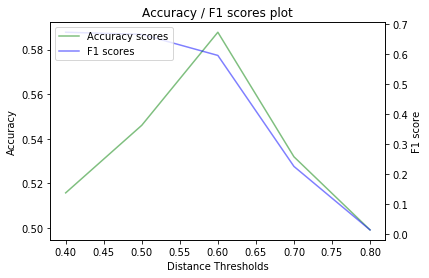

--- The most optimal threshold is: 0.4
Accuracy with threshold = 0.4, is = 0.5157
F1 score with threshold = 0.4, is = 0.6723
7. Averaged precision score is: 0.52
[0.01399378 0.1049551  0.39907521 0.86530594 0.99346098]
[0.9618564064124232, 0.8083945606132392, 0.4255832207788534, 0.06474298685410818, 0.000742505993084087]
Equal Error Rate is: 0.000742505993084087
8. Plotting ROC curve (TPR vs FPR)


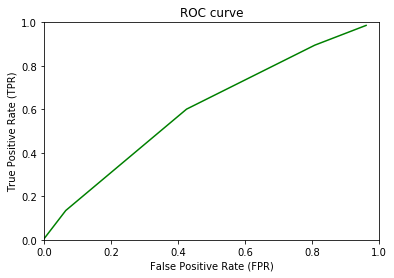

9. AUC score for thresholded distances is 0.568


In [23]:
embedded_lfw_pca = perform_method("PCA", faces_lfw)
perform_all_steps("PCA", faces_lfw, embedded_lfw_pca)

Number of components 30


/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


--- Choosed technique: LDA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


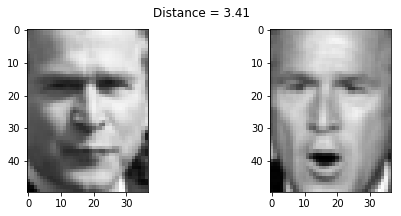

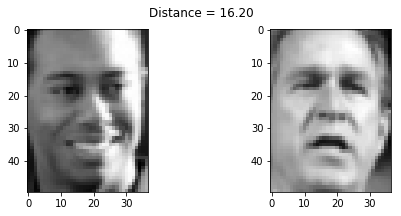

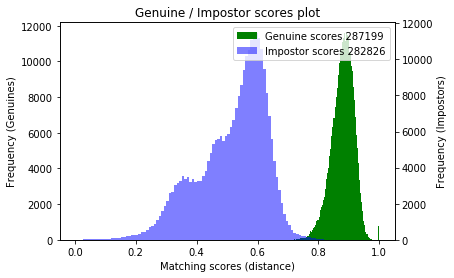

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.5899
F1 score with threshold = 0.4, is = 0.7107
Accuracy with threshold = 0.5, is = 0.6881
F1 score with threshold = 0.5, is = 0.7636
Accuracy with threshold = 0.6, is = 0.8737
F1 score with threshold = 0.6, is = 0.8886
Accuracy with threshold = 0.7, is = 0.9938
F1 score with threshold = 0.7, is = 0.9939
Accuracy with threshold = 0.8, is = 0.987
F1 score with threshold = 0.8, is = 0.9869
Optimal threshold = 0.7
6. Plotting F1 and accuracy scores 


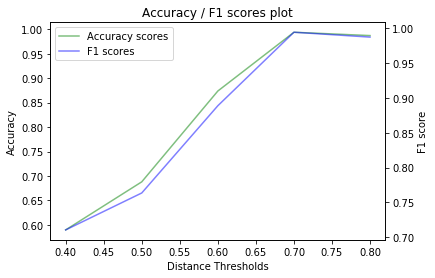

--- The most optimal threshold is: 0.7
Accuracy with threshold = 0.7, is = 0.9938
F1 score with threshold = 0.7, is = 0.9939
7. Averaged precision score is: 0.99
[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.17828753e-05
 2.55397825e-02]
[0.826614243386393, 0.628587895030867, 0.2545876263144124, 0.012498850883582132, 0.00034650279677257397]
Equal Error Rate is: 4.178287528855407e-05
8. Plotting ROC curve (TPR vs FPR)


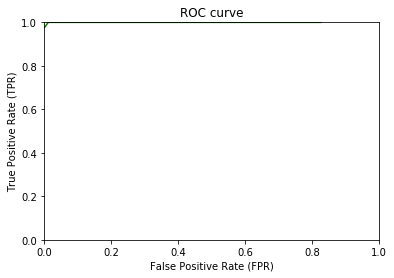

9. AUC score for thresholded distances is 0.826


In [24]:
embedded_lfw_lda = perform_method("LDA", faces_lfw)
perform_all_steps("LDA", faces_lfw, embedded_lfw_lda)

--- Choosed technique: LBP
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


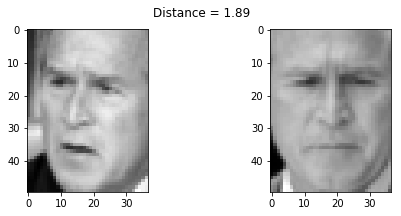

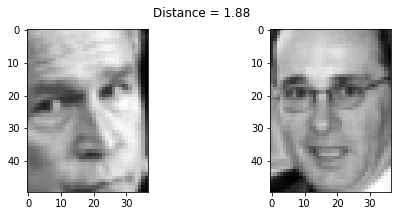

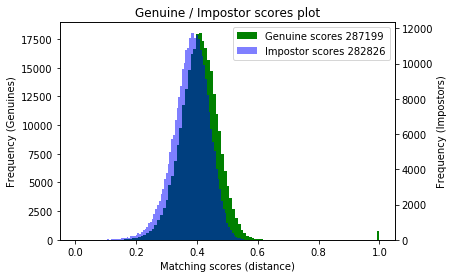

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.5825
F1 score with threshold = 0.4, is = 0.5738
Accuracy with threshold = 0.5, is = 0.5196
F1 score with threshold = 0.5, is = 0.1068
Accuracy with threshold = 0.6, is = 0.4978
F1 score with threshold = 0.6, is = 0.0063
Accuracy with threshold = 0.7, is = 0.4975
F1 score with threshold = 0.7, is = 0.0053
Accuracy with threshold = 0.8, is = 0.4975
F1 score with threshold = 0.8, is = 0.0052
Optimal threshold = 0.4
6. Plotting F1 and accuracy scores 


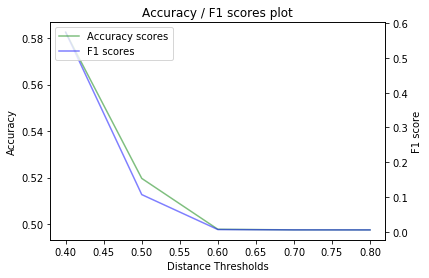

--- The most optimal threshold is: 0.4
Accuracy with threshold = 0.4, is = 0.5825
F1 score with threshold = 0.4, is = 0.5738
7. Averaged precision score is: 0.58
[0.44224736 0.94299075 0.99683843 0.99733286 0.99737464]
[0.3923437024884558, 0.010571871044387716, 0.0, 0.0, 0.0]
Equal Error Rate is: 0.3923437024884558
8. Plotting ROC curve (TPR vs FPR)


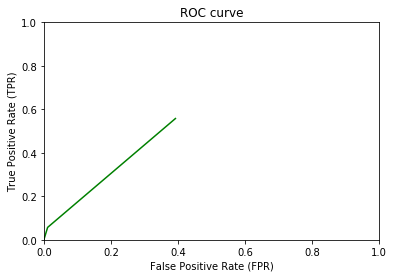

9. AUC score for thresholded distances is 0.118


In [25]:
embedded_lfw_lbp = perform_method("LBP", faces_lfw)
perform_all_steps("LBP", faces_lfw, embedded_lfw_lbp)

### Caltech faces dataset

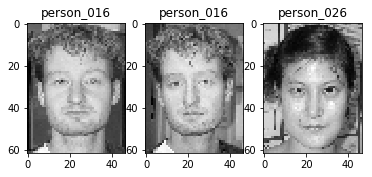

Total dataset size:
n_samples: 130
n_features: 2914
n_classes: 9


In [26]:
faces_caltech = get_faces("CALTECH")
plot_faces(faces_caltech)
get_data_statistics(faces_caltech)

Number of components 30
Explained variance [0.19475623 0.19140183 0.08828467 0.0466815  0.04069351 0.03358129
 0.03047567 0.0220804  0.01711269 0.01295449 0.01254745 0.01216403
 0.00993521 0.00906443 0.00874455 0.00809308 0.00724348 0.00679672
 0.0066385  0.00647999 0.00622246 0.00604653 0.00588411 0.00565799
 0.00548228 0.00521866 0.00481317 0.00456045 0.00451493 0.0044724 ]
--- Choosed technique: PCA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)


/anaconda2/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


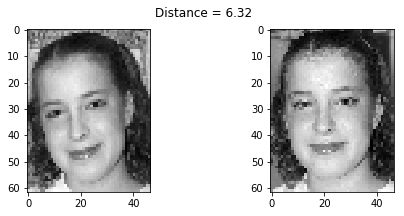

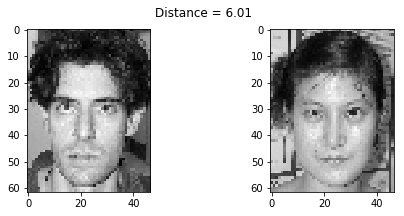

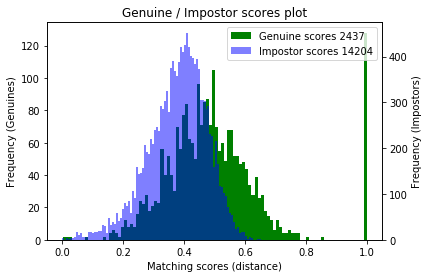

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.576
F1 score with threshold = 0.4, is = 0.3362
Accuracy with threshold = 0.5, is = 0.8405
F1 score with threshold = 0.5, is = 0.4334
Accuracy with threshold = 0.6, is = 0.8781
F1 score with threshold = 0.6, is = 0.2987
Accuracy with threshold = 0.7, is = 0.8643
F1 score with threshold = 0.7, is = 0.1361
Accuracy with threshold = 0.8, is = 0.8615
F1 score with threshold = 0.8, is = 0.1028
Optimal threshold = 0.5
6. Plotting F1 and accuracy scores 


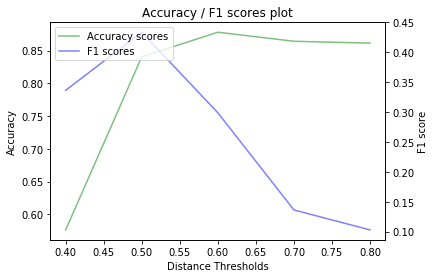

--- The most optimal threshold is: 0.5
Accuracy with threshold = 0.5, is = 0.8405
F1 score with threshold = 0.5, is = 0.4334
7. Averaged precision score is: 0.84
[0.26672138 0.58350431 0.82273287 0.92695938 0.94583504]
[0.4509293156857223, 0.08673613066741763, 0.0016896648831315122, 0.0, 0.0]
Equal Error Rate is: 0.4509293156857223
8. Plotting ROC curve (TPR vs FPR)


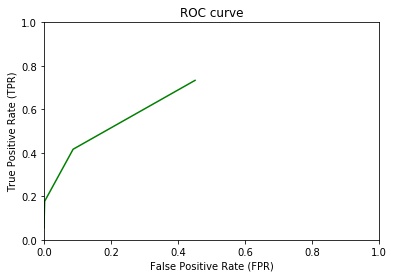

9. AUC score for thresholded distances is 0.235


In [27]:
embedded_caltech_pca = perform_method("PCA", faces_caltech)
perform_all_steps("PCA", faces_caltech, embedded_caltech_pca)

Number of components 30


/anaconda2/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


--- Choosed technique: LDA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


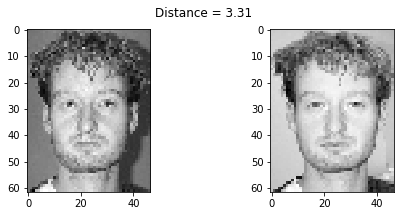

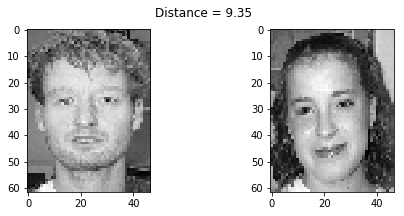

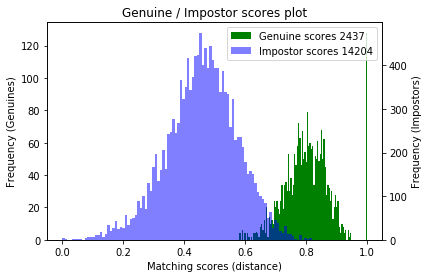

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.3905
F1 score with threshold = 0.4, is = 0.3246
Accuracy with threshold = 0.5, is = 0.6896
F1 score with threshold = 0.5, is = 0.4855
Accuracy with threshold = 0.6, is = 0.9123
F1 score with threshold = 0.6, is = 0.7686
Accuracy with threshold = 0.7, is = 0.9777
F1 score with threshold = 0.7, is = 0.924
Accuracy with threshold = 0.8, is = 0.9316
F1 score with threshold = 0.8, is = 0.696
Optimal threshold = 0.7
6. Plotting F1 and accuracy scores 


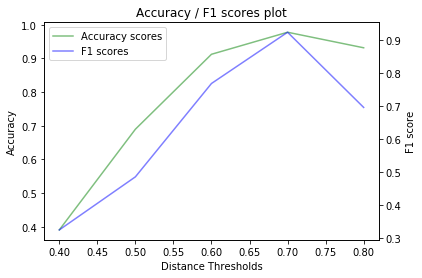

--- The most optimal threshold is: 0.7
Accuracy with threshold = 0.7, is = 0.9777
F1 score with threshold = 0.7, is = 0.924
7. Averaged precision score is: 0.98
[0.         0.         0.00492409 0.07427165 0.46491588]
[0.7140946212334554, 0.3636299633905942, 0.10194311461560124, 0.013376513658124471, 0.00042241622078287804]
Equal Error Rate is: 0.0
8. Plotting ROC curve (TPR vs FPR)


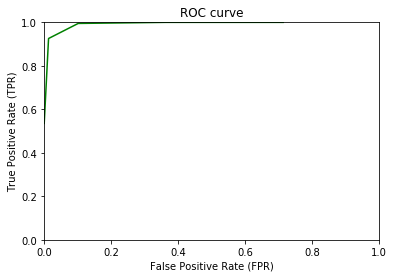

9. AUC score for thresholded distances is 0.706


In [28]:
embedded_caltech_lda = perform_method("LDA", faces_caltech)
perform_all_steps("LDA", faces_caltech, embedded_caltech_lda)

/anaconda2/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


--- Choosed technique: LBP
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


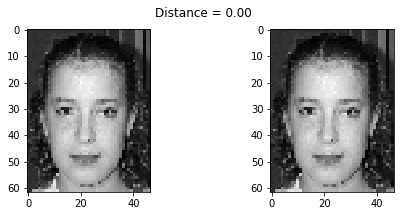

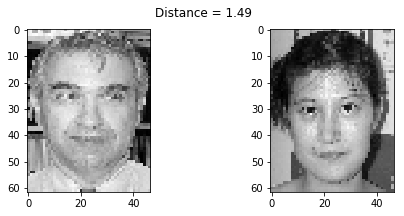

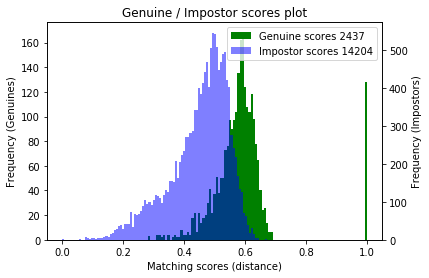

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.3555
F1 score with threshold = 0.4, is = 0.3086
Accuracy with threshold = 0.5, is = 0.679
F1 score with threshold = 0.5, is = 0.4459
Accuracy with threshold = 0.6, is = 0.8966
F1 score with threshold = 0.6, is = 0.5072
Accuracy with threshold = 0.7, is = 0.8612
F1 score with threshold = 0.7, is = 0.0998
Accuracy with threshold = 0.8, is = 0.8612
F1 score with threshold = 0.8, is = 0.0998
Optimal threshold = 0.6
6. Plotting F1 and accuracy scores 


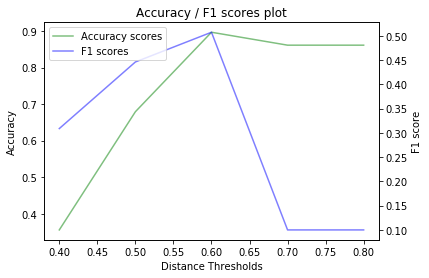

--- The most optimal threshold is: 0.6
Accuracy with threshold = 0.6, is = 0.8966
F1 score with threshold = 0.6, is = 0.5072
7. Averaged precision score is: 0.9
[0.01764465 0.11817809 0.63684858 0.94747641 0.94747641]
[0.7520416784004506, 0.35574486060264715, 0.011827654181920586, 0.0, 0.0]
Equal Error Rate is: 0.011827654181920586
8. Plotting ROC curve (TPR vs FPR)


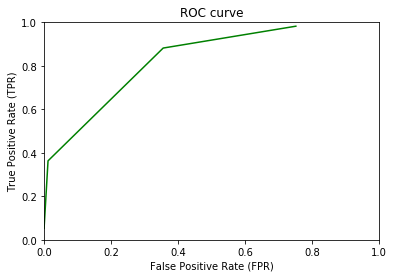

9. AUC score for thresholded distances is 0.586


In [29]:
embedded_caltech_lbp = perform_method("LBP", faces_caltech)
perform_all_steps("LBP", faces_caltech, embedded_caltech_lbp)

### Conclusion

LDA shows best results compared to the other two approaches: PCA and LBP.

# Classfication scenario
In the following section we analyse two different approaches in the field of biometric systems: identification and authentication scenarios. After this, a more general classification scenario is examined, by using machine learning algorithms like k-NN and SVM.
Similar as above, this is tested for all three datasets.

## Identification scenario
Identification scenario in biometric systems corresponds to 1:M clasification problem and tries to answer the question: "Who are you?".
Firstly, we prepare the dataset: splitting into separate train and test datasets.

We define few methods that will allow us to perform the identification scenario.

In [30]:
def get_L2_distances(query_img, X_train, y_train):
    '''
    Computes L2 distance between the query image and all other images in the train set.
    Returns sorted list of tuples: (img_id, distnce), where img_id is id of image in the train set
    and distance is the distance between the query image and the img_id.
    '''
    distances = []
    for i in range(0, len(X_train)):
        dist = L2_distance(query_img, X_train[i])
        distances.append((y_train[i], dist))
        
    return sorted(distances, key = operator.itemgetter(1)) # sort according to distance

In [31]:
from collections import defaultdict

def get_ranked_images(distances, rank):
    '''
    Counts how many faces from the same class are there in the first ranked ones
    :param distances: distaces from given query face to all training faces
    :param rank: take the first ranked closest features
    :return first_rank_sorted: dictionary, where key denotes the face class and 
            the value is how many times it appears in the first ranked faces
    '''
    first_ranked = defaultdict(int)
    for i, dist in distances[0:rank]:
        first_ranked[i] += 1
            
    first_rank_sorted = sorted(first_ranked.items(), key = operator.itemgetter(1), reverse=True) 
    return first_rank_sorted    

This method works on the basis of Nearest Neighbors approach, where the value of rank is the "k" in kNN. First the distances between a query image and all training data is computed and sorted in ascending order. Then the first ranked distances are taken and it is checked which ones belong to which class. The class with the most close faces to the query one, is taken as a predicted class. Also, a probability that the face will be contained in the first ranked faces is computed and then averaged for all query images for that rank. The CMC curve is obtained by plotting these probabiities and range of ranks.

In [32]:
# Definition of identification scenario
def perform_identification_scenario(X_train, y_train, X_test, y_test, rank):
    true_y = []
    pred_y = []
    total_prob = 0
    print("----- START, rank = {} -----".format(rank))
    for i in range(0, len(X_test)):
        # Get the distances between the query image and all other training images
        L2_distances = get_L2_distances(X_test[i], X_train, y_train)  # dictionary

        # Get the first closest face classes according to the given rank
        first_ranked = get_ranked_images(L2_distances, rank)

        # The highest ranked class is taken as predicted class
        predicted_class = first_ranked[0][0]
        
        # Compute the probability that the query face shows up in the first ranked 
        prob = first_ranked[0][1] / len(np.unique(y_train)) 
        total_prob += prob
        true_y.append(1) # true_class
        if y_test[i] != predicted_class:
            pred_y.append(0) # wrong prediction
        else:
            pred_y.append(1) # correct prediction
        
        closest_img_id = L2_distances[0][0]
        closest_img = X_train[closest_img_id]
#         print('--- Query face ID: {}'.format(y_test[i]))
#         print('Best matching face ID: {}'.format(closest_img_id))
    
    avg_probability = total_prob/len(X_test)
    print("Averaged probability for rank %d is %f "%(rank, round(avg_probability,4)))
    print("Accuracy is %f "%(round(accuracy_score(true_y, pred_y),4)))
    return avg_probability

In [33]:
def perform_identification_with_ranks(X_train, y_train, X_test, y_test, rank_range):
    '''
    Perform the above method for a range of ranks.
    '''
    avg_probabilities = []
    for rank in rank_range:
        avg_probabilities.append(
            perform_identification_scenario(X_train, y_train, X_test, y_test, rank))
        
    return avg_probabilities

In [34]:
def perform_all_steps_identification(DESC, faces, embedded):
    print('1. Splitting the dataset into train and test')
    X_train, X_test, y_train, y_test = get_train_test_sets(embedded, faces.target)
    
    rank_range = range(2, 10, 1) # only odd numbers as rank
    
    print('2. Performing identification scenario for a range of ranks')
    avg_probabilities = perform_identification_with_ranks(X_train, y_train, X_test, y_test, rank_range)
    
    print('3. Generating CMC curve with the averadged probabilities according to the ranks')
    get_cmc_curve(rank_range, avg_probabilities)

### AT&T Facedatabase

1. Splitting the dataset into train and test
2. Performing identification scenario for a range of ranks
----- START, rank = 2 -----
Averaged probability for rank 2 is 0.203100 
Accuracy is 0.958300 
----- START, rank = 3 -----
Averaged probability for rank 3 is 0.239600 
Accuracy is 0.958300 
----- START, rank = 4 -----
Averaged probability for rank 4 is 0.270800 
Accuracy is 0.916700 
----- START, rank = 5 -----
Averaged probability for rank 5 is 0.307300 
Accuracy is 0.791700 
----- START, rank = 6 -----
Averaged probability for rank 6 is 0.333300 
Accuracy is 0.750000 
----- START, rank = 7 -----
Averaged probability for rank 7 is 0.354200 
Accuracy is 0.666700 
----- START, rank = 8 -----
Averaged probability for rank 8 is 0.364600 
Accuracy is 0.708300 
----- START, rank = 9 -----
Averaged probability for rank 9 is 0.380200 
Accuracy is 0.625000 
3. Generating CMC curve with the averadged probabilities according to the ranks


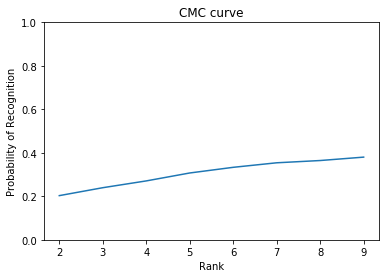

In [35]:
perform_all_steps_identification("PCA", faces_att, embedded_att_pca)

1. Splitting the dataset into train and test
2. Performing identification scenario for a range of ranks
----- START, rank = 2 -----
Averaged probability for rank 2 is 0.250000 
Accuracy is 0.958300 
----- START, rank = 3 -----
Averaged probability for rank 3 is 0.369800 
Accuracy is 0.958300 
----- START, rank = 4 -----
Averaged probability for rank 4 is 0.489600 
Accuracy is 0.958300 
----- START, rank = 5 -----
Averaged probability for rank 5 is 0.614600 
Accuracy is 1.000000 
----- START, rank = 6 -----
Averaged probability for rank 6 is 0.739600 
Accuracy is 1.000000 
----- START, rank = 7 -----
Averaged probability for rank 7 is 0.770800 
Accuracy is 1.000000 
----- START, rank = 8 -----
Averaged probability for rank 8 is 0.781200 
Accuracy is 0.958300 
----- START, rank = 9 -----
Averaged probability for rank 9 is 0.796900 
Accuracy is 1.000000 
3. Generating CMC curve with the averadged probabilities according to the ranks


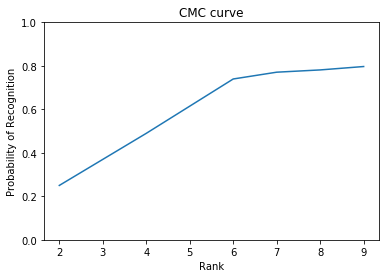

In [36]:
perform_all_steps_identification("LDA", faces_att, embedded_att_lda)

1. Splitting the dataset into train and test
2. Performing identification scenario for a range of ranks
----- START, rank = 2 -----
Averaged probability for rank 2 is 0.239600 
Accuracy is 1.000000 
----- START, rank = 3 -----
Averaged probability for rank 3 is 0.359400 
Accuracy is 0.916700 
----- START, rank = 4 -----
Averaged probability for rank 4 is 0.432300 
Accuracy is 1.000000 
----- START, rank = 5 -----
Averaged probability for rank 5 is 0.505200 
Accuracy is 1.000000 
----- START, rank = 6 -----
Averaged probability for rank 6 is 0.557300 
Accuracy is 1.000000 
----- START, rank = 7 -----
Averaged probability for rank 7 is 0.593800 
Accuracy is 1.000000 
----- START, rank = 8 -----
Averaged probability for rank 8 is 0.619800 
Accuracy is 0.958300 
----- START, rank = 9 -----
Averaged probability for rank 9 is 0.645800 
Accuracy is 0.958300 
3. Generating CMC curve with the averadged probabilities according to the ranks


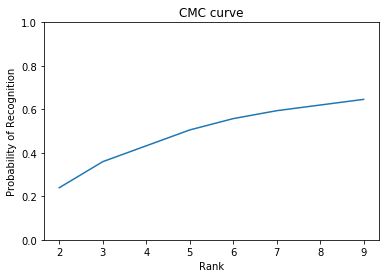

In [37]:
perform_all_steps_identification("LBP", faces_att, embedded_att_lbp)

### Labeled Faces in the Wild

1. Splitting the dataset into train and test
2. Performing identification scenario for a range of ranks
----- START, rank = 2 -----
Averaged probability for rank 2 is 0.176700 
Accuracy is 0.779700 
----- START, rank = 3 -----
Averaged probability for rank 3 is 0.259000 
Accuracy is 0.793000 
----- START, rank = 4 -----
Averaged probability for rank 4 is 0.334400 
Accuracy is 0.775300 
----- START, rank = 5 -----
Averaged probability for rank 5 is 0.408800 
Accuracy is 0.779700 
----- START, rank = 6 -----
Averaged probability for rank 6 is 0.485500 
Accuracy is 0.779700 
----- START, rank = 7 -----
Averaged probability for rank 7 is 0.561700 
Accuracy is 0.762100 
----- START, rank = 8 -----
Averaged probability for rank 8 is 0.637400 
Accuracy is 0.757700 
----- START, rank = 9 -----
Averaged probability for rank 9 is 0.714500 
Accuracy is 0.757700 
3. Generating CMC curve with the averadged probabilities according to the ranks


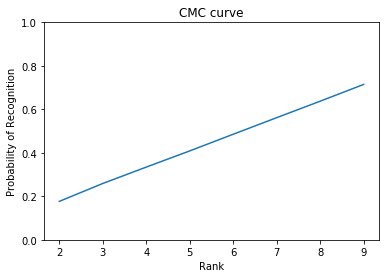

In [38]:
perform_all_steps_identification("PCA", faces_lfw, embedded_lfw_pca)

1. Splitting the dataset into train and test
2. Performing identification scenario for a range of ranks
----- START, rank = 2 -----
Averaged probability for rank 2 is 0.200000 
Accuracy is 1.000000 
----- START, rank = 3 -----
Averaged probability for rank 3 is 0.300000 
Accuracy is 1.000000 
----- START, rank = 4 -----
Averaged probability for rank 4 is 0.400000 
Accuracy is 1.000000 
----- START, rank = 5 -----
Averaged probability for rank 5 is 0.500000 
Accuracy is 1.000000 
----- START, rank = 6 -----
Averaged probability for rank 6 is 0.600000 
Accuracy is 1.000000 
----- START, rank = 7 -----
Averaged probability for rank 7 is 0.698200 
Accuracy is 1.000000 
----- START, rank = 8 -----
Averaged probability for rank 8 is 0.796500 
Accuracy is 1.000000 
----- START, rank = 9 -----
Averaged probability for rank 9 is 0.894700 
Accuracy is 1.000000 
3. Generating CMC curve with the averadged probabilities according to the ranks


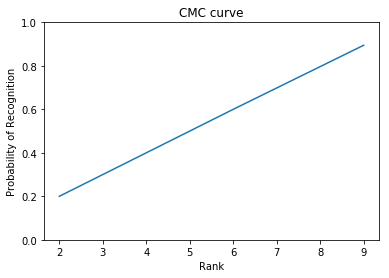

In [39]:
perform_all_steps_identification("LDA", faces_lfw, embedded_lfw_lda)

1. Splitting the dataset into train and test
2. Performing identification scenario for a range of ranks
----- START, rank = 2 -----
Averaged probability for rank 2 is 0.173600 
Accuracy is 0.823800 
----- START, rank = 3 -----
Averaged probability for rank 3 is 0.257300 
Accuracy is 0.801800 
----- START, rank = 4 -----
Averaged probability for rank 4 is 0.338800 
Accuracy is 0.806200 
----- START, rank = 5 -----
Averaged probability for rank 5 is 0.417600 
Accuracy is 0.801800 
----- START, rank = 6 -----
Averaged probability for rank 6 is 0.494700 
Accuracy is 0.801800 
----- START, rank = 7 -----
Averaged probability for rank 7 is 0.571400 
Accuracy is 0.806200 
----- START, rank = 8 -----
Averaged probability for rank 8 is 0.650200 
Accuracy is 0.793000 
----- START, rank = 9 -----
Averaged probability for rank 9 is 0.719800 
Accuracy is 0.784100 
3. Generating CMC curve with the averadged probabilities according to the ranks


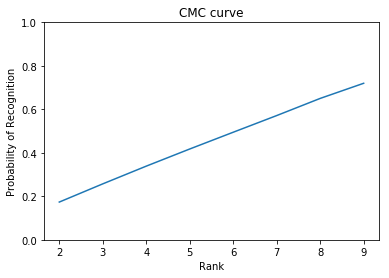

In [40]:
perform_all_steps_identification("LBP", faces_lfw, embedded_lfw_lbp)

### Caltech Faces Database

1. Splitting the dataset into train and test
2. Performing identification scenario for a range of ranks
----- START, rank = 2 -----
Averaged probability for rank 2 is 0.188000 
Accuracy is 0.871800 
----- START, rank = 3 -----
Averaged probability for rank 3 is 0.273500 
Accuracy is 0.846200 
----- START, rank = 4 -----
Averaged probability for rank 4 is 0.353300 
Accuracy is 0.820500 
----- START, rank = 5 -----
Averaged probability for rank 5 is 0.421700 
Accuracy is 0.820500 
----- START, rank = 6 -----
Averaged probability for rank 6 is 0.472900 
Accuracy is 0.769200 
----- START, rank = 7 -----
Averaged probability for rank 7 is 0.527100 
Accuracy is 0.743600 
----- START, rank = 8 -----
Averaged probability for rank 8 is 0.558400 
Accuracy is 0.717900 
----- START, rank = 9 -----
Averaged probability for rank 9 is 0.601100 
Accuracy is 0.743600 
3. Generating CMC curve with the averadged probabilities according to the ranks


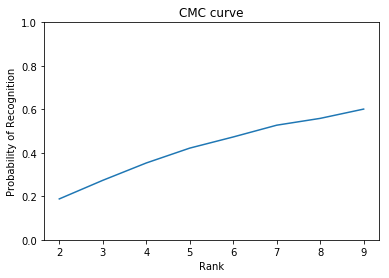

In [71]:
perform_all_steps_identification("PCA", faces_caltech, embedded_caltech_pca)

1. Splitting the dataset into train and test
2. Performing identification scenario for a range of ranks
----- START, rank = 2 -----
Averaged probability for rank 2 is 0.222200 
Accuracy is 1.000000 
----- START, rank = 3 -----
Averaged probability for rank 3 is 0.321900 
Accuracy is 1.000000 
----- START, rank = 4 -----
Averaged probability for rank 4 is 0.418800 
Accuracy is 1.000000 
----- START, rank = 5 -----
Averaged probability for rank 5 is 0.512800 
Accuracy is 1.000000 
----- START, rank = 6 -----
Averaged probability for rank 6 is 0.609700 
Accuracy is 0.974400 
----- START, rank = 7 -----
Averaged probability for rank 7 is 0.712300 
Accuracy is 0.897400 
----- START, rank = 8 -----
Averaged probability for rank 8 is 0.814800 
Accuracy is 0.871800 
----- START, rank = 9 -----
Averaged probability for rank 9 is 0.917400 
Accuracy is 0.871800 
3. Generating CMC curve with the averadged probabilities according to the ranks


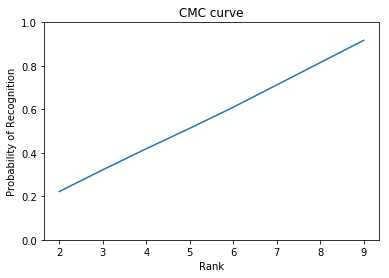

In [72]:
perform_all_steps_identification("LDA", faces_caltech, embedded_caltech_lda)

1. Splitting the dataset into train and test
2. Performing identification scenario for a range of ranks
----- START, rank = 2 -----
Averaged probability for rank 2 is 0.199400 
Accuracy is 0.897400 
----- START, rank = 3 -----
Averaged probability for rank 3 is 0.282100 
Accuracy is 0.923100 
----- START, rank = 4 -----
Averaged probability for rank 4 is 0.370400 
Accuracy is 0.923100 
----- START, rank = 5 -----
Averaged probability for rank 5 is 0.458700 
Accuracy is 0.923100 
----- START, rank = 6 -----
Averaged probability for rank 6 is 0.535600 
Accuracy is 0.923100 
----- START, rank = 7 -----
Averaged probability for rank 7 is 0.621100 
Accuracy is 0.871800 
----- START, rank = 8 -----
Averaged probability for rank 8 is 0.698000 
Accuracy is 0.871800 
----- START, rank = 9 -----
Averaged probability for rank 9 is 0.774900 
Accuracy is 0.871800 
3. Generating CMC curve with the averadged probabilities according to the ranks


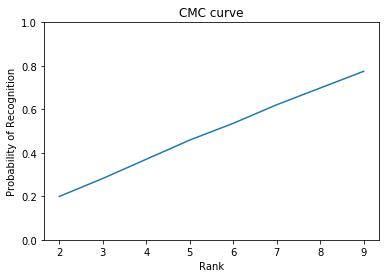

In [73]:
perform_all_steps_identification("LBP", faces_caltech, embedded_caltech_lbp)

### Conclusion

For all three datasets, LDA show best results. Also, LBP shows good performance, very close to LDA. At last, PCA is worse compared to LDA and LBP, as it was also in the previous section.

## Authentication scenario
The authentication scenario corresponds to a binary classification problem. 
It tries to decide whether a certain query face, should be authenticated as true compared to a database with examples from that class. For example, to use the iPhone's authentication system with faces, first the person should scan its face from different angles and position, thus creating a database with its facial looks and characteristics. Then, each time when he wants to authenticate, he scans his face which represents the query face image and the system decides whether to unlock the phone or not. Following this use case, we do a small modification in the structure of the training set. The faces that belong to a certain class, are splitted into separate dictionaries, so that each dictionary contains only faces from one person. Then we iterate through the test set, and each query face is compared to the stored faces in the autentication databases i.e. the dictionaries.

In [44]:
def count_same_faces(feature_distances, dist_threshold):
    '''
    Counts how many faces are close to the query face
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param dist_threshold: Predefined value for the threshold
    :return count_same: number of same face paris 
    '''
    count_same = 0
    for features in feature_distances:
        if features >= dist_threshold: # Compare the len of best features for the given feature with the predefined len
            count_same += 1
            
    return count_same

In [45]:
def get_L2_distances_auth(query_img, authentication_db):
    distances = []
    for class_img, auth_img in authentication_db:
        dist = L2_distance(query_img, auth_img)
        distances.append(dist)
        
    distances = sorted(distances) # sort by value - feature distance
    distances_norm = (np.max(distances) - distances) / np.max(distances)
    return distances_norm


In [46]:
def perform_authentication_scenario(authentication_databases, X_test, y_test, dist_threshold):
    true_y = []
    pred_y = []
    distances_arr = []
    identical = []
    print("----- START, Threshold = {} -----".format(round(dist_threshold,2)))
    for authentication_db_key in authentication_databases.keys():
        authentication_db = authentication_databases[authentication_db_key]
        for i in range(len(X_test)):    
            distances = get_L2_distances_auth(X_test[i], authentication_db) # feature distances between the query fpr and the training fprs
            distances_arr.append(distances)
            count_same = count_same_faces(distances, dist_threshold)
            genuine_ratio = count_same/len(authentication_db)
            true_class = 1 if y_test[i] == authentication_db_key else 0
            true_y.append(true_class)
            
            if genuine_ratio >= 0.5: 
                pred_y.append(1)
            else:
                pred_y.append(0) 
                    
            #print('--- For query image: {} ---'.format(y_test[i]))
            #print('Probability of correct faces = {}'.format(genuine_ratio))
    identical = true_y
    tn, fp, fn, tp = confusion_matrix(true_y, pred_y).ravel()
    #print('Confusion matrix: tp = {}, fp = {}, fn = {}, tn = {}'.format(tp, fp, fn, tn))
    print('The precision score is {}'.format(round(precision_score(true_y, pred_y),4)))
    print('The accurcy score is {}'.format(round(accuracy_score(true_y, pred_y),4)))
    true_pos_rate, false_pos_rate = calculate_ratios(tp, fp, fn, tn)
    return true_pos_rate, false_pos_rate, distances_arr, identical

Next, we perform the authentiction scenario by iterating through different distance thresholds. We accumulate two lists with the false accept rates (FAR) and false reject rates (FRR). Then we plot the ROC curve according to these rates.

In [47]:
def perform_all_steps_authentication(DESC, faces, embedded):
    distances_accumulate = []    
    identical_accumulate = []

    print('1. Splitting the dataset into train and test')
    
    X_train, X_test, y_train, y_test = get_train_test_sets(embedded, faces.target)
        
    authentication_databases = prepare_dataset_authentication(X_train, y_train)
    
    false_accept_rates = []
    false_reject_rates = []
    thresholds = np.arange(0.10, 0.70, 0.10)

    print('2. Performing authentication scenario for a range of thresholds')
    for dist_threshold in thresholds: 
        true_pos_rate, false_pos_rate, distances_arr, identical = perform_authentication_scenario(
                                                                        authentication_databases, 
                                                                        X_test, y_test, dist_threshold)
        distances_arr = np.asarray(distances_arr).flatten()
        identical = np.asarray(identical).flatten()
        distances_accumulate.append(distances_arr)
        identical_accumulate.append(identical)
        false_reject_rates.append(1-true_pos_rate)
        false_accept_rates.append(false_pos_rate)         
   
    print('3. Generating ROC curve: False accept rates vs. false reject rates')
    get_roc_curve_frr_far(false_reject_rates, false_accept_rates)
   

For evaluation of the system, we use the ROC curve, with small modification: the FAR and FRR are plotted, instead of the standard version with TPR and FPR. The goal is to obtain a curve which is close to the left bottom corner - close to the coordinate center (0, 0).

### AT&T Facedatabase

1. Splitting the dataset into train and test
2. Performing authentication scenario for a range of thresholds
----- START, Threshold = 0.1 -----
The precision score is 0.1452
The accurcy score is 0.4167
----- START, Threshold = 0.2 -----
The precision score is 0.4737
The accurcy score is 0.8698
----- START, Threshold = 0.3 -----
The precision score is 1.0
The accurcy score is 0.8958
----- START, Threshold = 0.4 -----
The precision score is 1.0
The accurcy score is 0.8854
----- START, Threshold = 0.5 -----
The precision score is 1.0
The accurcy score is 0.8854
----- START, Threshold = 0.6 -----
The precision score is 0.0
The accurcy score is 0.875
3. Generating ROC curve: False accept rates vs. false reject rates


/anaconda2/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


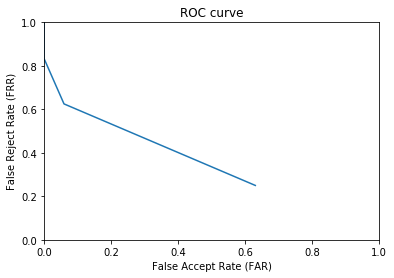

In [48]:
perform_all_steps_authentication("PCA", faces_att, embedded_att_pca)


1. Splitting the dataset into train and test
2. Performing authentication scenario for a range of thresholds
----- START, Threshold = 0.1 -----
The precision score is 0.1789
The accurcy score is 0.4635
----- START, Threshold = 0.2 -----
The precision score is 0.5455
The accurcy score is 0.8906
----- START, Threshold = 0.3 -----
The precision score is 1.0
The accurcy score is 0.9375
----- START, Threshold = 0.4 -----
The precision score is 1.0
The accurcy score is 0.8802
----- START, Threshold = 0.5 -----
The precision score is 0.0
The accurcy score is 0.875
----- START, Threshold = 0.6 -----
The precision score is 0.0
The accurcy score is 0.875
3. Generating ROC curve: False accept rates vs. false reject rates


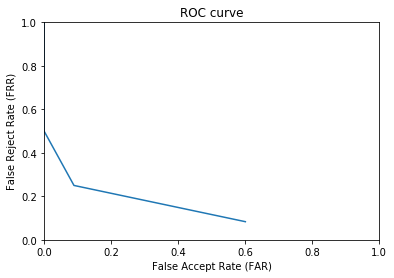

In [49]:
perform_all_steps_authentication("LDA", faces_att, embedded_att_lda)


1. Splitting the dataset into train and test
2. Performing authentication scenario for a range of thresholds
----- START, Threshold = 0.1 -----
The precision score is 0.2436
The accurcy score is 0.6667
----- START, Threshold = 0.2 -----
The precision score is 0.6667
The accurcy score is 0.8854
----- START, Threshold = 0.3 -----
The precision score is 0.0
The accurcy score is 0.875
----- START, Threshold = 0.4 -----
The precision score is 0.0
The accurcy score is 0.875
----- START, Threshold = 0.5 -----
The precision score is 0.0
The accurcy score is 0.875
----- START, Threshold = 0.6 -----
The precision score is 0.0
The accurcy score is 0.875
3. Generating ROC curve: False accept rates vs. false reject rates


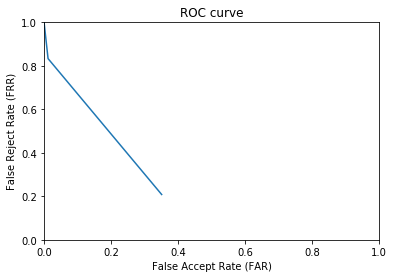

In [50]:
perform_all_steps_authentication("LBP", faces_att, embedded_att_lbp)

### Labeled Faces in the Wild

1. Splitting the dataset into train and test
2. Performing authentication scenario for a range of thresholds
----- START, Threshold = 0.1 -----
The precision score is 0.1026
The accurcy score is 0.1256
----- START, Threshold = 0.2 -----
The precision score is 0.1237
The accurcy score is 0.3128
----- START, Threshold = 0.3 -----
The precision score is 0.238
The accurcy score is 0.7264
----- START, Threshold = 0.4 -----
The precision score is 0.6803
The accurcy score is 0.9194
----- START, Threshold = 0.5 -----
The precision score is 0.0
The accurcy score is 0.9
----- START, Threshold = 0.6 -----
The precision score is 0.0
The accurcy score is 0.9
3. Generating ROC curve: False accept rates vs. false reject rates


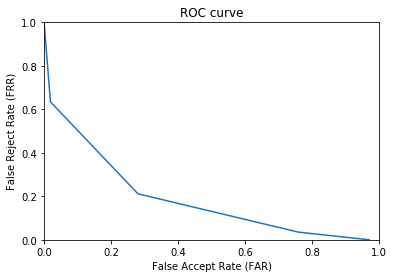

In [51]:
perform_all_steps_authentication("PCA", faces_lfw, embedded_lfw_pca)

1. Splitting the dataset into train and test
2. Performing authentication scenario for a range of thresholds
----- START, Threshold = 0.1 -----
The precision score is 0.197
The accurcy score is 0.5925
----- START, Threshold = 0.2 -----
The precision score is 0.902
The accurcy score is 0.9868
----- START, Threshold = 0.3 -----
The precision score is 1.0
The accurcy score is 0.989
----- START, Threshold = 0.4 -----
The precision score is 1.0
The accurcy score is 0.9727
----- START, Threshold = 0.5 -----
The precision score is 1.0
The accurcy score is 0.9352
----- START, Threshold = 0.6 -----
The precision score is 1.0
The accurcy score is 0.9013
3. Generating ROC curve: False accept rates vs. false reject rates


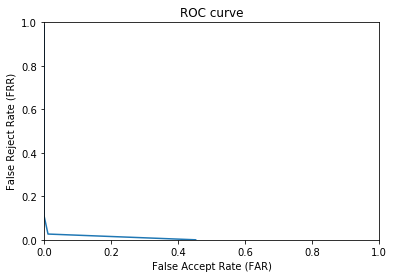

In [52]:
perform_all_steps_authentication("LDA", faces_lfw, embedded_lfw_lda)

1. Splitting the dataset into train and test
2. Performing authentication scenario for a range of thresholds
----- START, Threshold = 0.1 -----
The precision score is 0.1824
The accurcy score is 0.6101
----- START, Threshold = 0.2 -----
The precision score is 0.5
The accurcy score is 0.9
----- START, Threshold = 0.3 -----
The precision score is 0.0
The accurcy score is 0.9
----- START, Threshold = 0.4 -----
The precision score is 0.0
The accurcy score is 0.9
----- START, Threshold = 0.5 -----
The precision score is 0.0
The accurcy score is 0.9
----- START, Threshold = 0.6 -----
The precision score is 0.0
The accurcy score is 0.9
3. Generating ROC curve: False accept rates vs. false reject rates


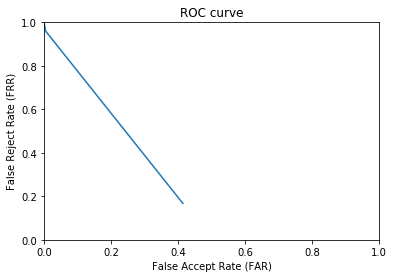

In [53]:
perform_all_steps_authentication("LBP", faces_lfw, embedded_lfw_lbp)

### Caltech Faces Dataset

1. Splitting the dataset into train and test
2. Performing authentication scenario for a range of thresholds
----- START, Threshold = 0.1 -----
The precision score is 0.1303
The accurcy score is 0.2906
----- START, Threshold = 0.2 -----
The precision score is 0.2453
The accurcy score is 0.735
----- START, Threshold = 0.3 -----
The precision score is 0.5333
The accurcy score is 0.8917
----- START, Threshold = 0.4 -----
The precision score is 1.0
The accurcy score is 0.8946
----- START, Threshold = 0.5 -----
The precision score is 0.0
The accurcy score is 0.8889
----- START, Threshold = 0.6 -----
The precision score is 0.0
The accurcy score is 0.8889
3. Generating ROC curve: False accept rates vs. false reject rates


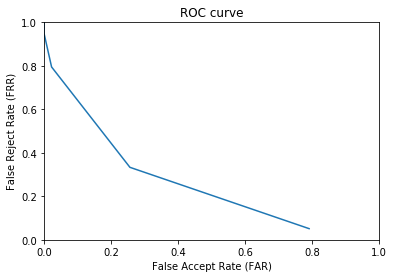

In [54]:
perform_all_steps_authentication("PCA", faces_caltech, embedded_caltech_pca)

1. Splitting the dataset into train and test
2. Performing authentication scenario for a range of thresholds
----- START, Threshold = 0.1 -----
The precision score is 0.1532
The accurcy score is 0.4245
----- START, Threshold = 0.2 -----
The precision score is 0.3535
The accurcy score is 0.8063
----- START, Threshold = 0.3 -----
The precision score is 0.6765
The accurcy score is 0.9231
----- START, Threshold = 0.4 -----
The precision score is 1.0
The accurcy score is 0.9231
----- START, Threshold = 0.5 -----
The precision score is 1.0
The accurcy score is 0.9003
----- START, Threshold = 0.6 -----
The precision score is 0.0
The accurcy score is 0.8889
3. Generating ROC curve: False accept rates vs. false reject rates


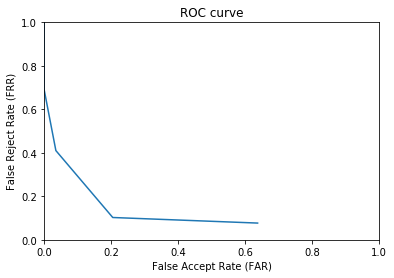

In [55]:
perform_all_steps_authentication("LDA", faces_caltech, embedded_caltech_lda)

1. Splitting the dataset into train and test
2. Performing authentication scenario for a range of thresholds
----- START, Threshold = 0.1 -----
The precision score is 0.1494
The accurcy score is 0.5413
----- START, Threshold = 0.2 -----
The precision score is 0.2917
The accurcy score is 0.8604
----- START, Threshold = 0.3 -----
The precision score is 0.0
The accurcy score is 0.8889
----- START, Threshold = 0.4 -----
The precision score is 0.0
The accurcy score is 0.8889
----- START, Threshold = 0.5 -----
The precision score is 0.0
The accurcy score is 0.8889
----- START, Threshold = 0.6 -----
The precision score is 0.0
The accurcy score is 0.8889
3. Generating ROC curve: False accept rates vs. false reject rates


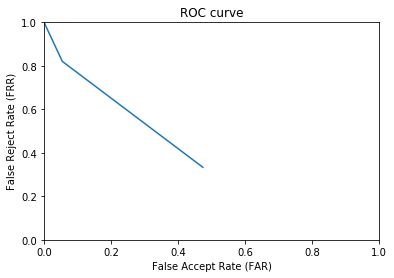

In [56]:
perform_all_steps_authentication("LBP", faces_caltech, embedded_caltech_lbp)

### Conclusion

Similarly as the above cases, LDA performs best compared to LBP and PCA. The results obtained with LBP are also satisfying and close to LDA ones.

### More general classification case (kNN and SVM)
- Multiclassification case


In [57]:
def kNN(k, X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    acc_knn = accuracy_score(y_test, knn.predict(X_test))
    print('kNN with k = {} has accuracy = {}'.format(k, round(acc_knn,4)))


In [58]:
def SVM(X_train, y_train, X_test, y_test):
    svc = LinearSVC()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    svc = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), 
                       param_grid, cv=5)
    svc.fit(X_train, y_train)
    acc_svc = accuracy_score(y_test, svc.predict(X_test))
    print('SVM - accuracy = {}'.format(round(acc_svc,4)))

In [64]:
def perform_kNN(DESC, faces, embedded):     
    print('--- For: {} ---'.format(DESC))
    le = LabelEncoder()
    faces.target = le.fit_transform(faces.target)
    X_train, X_test, y_train, y_test = get_train_test_sets(embedded, faces.target)

    for k in range(1,9,2):
        kNN(k, X_train, y_train, X_test, y_test)

    

In [65]:
def perform_SVM(DESC, faces, embedded):     
    print('--- For: {} ---'.format(DESC))
    X_train, X_test, y_train, y_test = get_train_test_sets(embedded, faces.target)
    SVM(X_train, y_train, X_test, y_test)
    

### AT&T Faces Database

In [66]:
perform_kNN("PCA", faces_att, embedded_att_pca)
perform_kNN("LDA", faces_att, embedded_att_lda)
perform_kNN("LBP", faces_att, embedded_att_lbp)

--- For: PCA ---
kNN with k = 1 has accuracy = 0.9583
kNN with k = 3 has accuracy = 0.9167
kNN with k = 5 has accuracy = 0.625
kNN with k = 7 has accuracy = 0.5
--- For: LDA ---
kNN with k = 1 has accuracy = 0.9583
kNN with k = 3 has accuracy = 0.9583
kNN with k = 5 has accuracy = 1.0
kNN with k = 7 has accuracy = 1.0
--- For: LBP ---
kNN with k = 1 has accuracy = 1.0
kNN with k = 3 has accuracy = 0.9167
kNN with k = 5 has accuracy = 1.0
kNN with k = 7 has accuracy = 0.9583


In [62]:
perform_SVM("PCA", faces_att, embedded_att_pca)
perform_SVM("LDA", faces_att, embedded_att_lda)
perform_SVM("LBP", faces_att, embedded_att_lbp)

--- For: PCA ---


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVM - accuracy = 0.9583
--- For: LDA ---


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVM - accuracy = 0.9583
--- For: LBP ---
SVM - accuracy = 1.0


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### LFW Dataset

In [74]:
perform_kNN("PCA", faces_lfw, embedded_lfw_pca)
perform_kNN("LDA", faces_lfw, embedded_lfw_lda)
perform_kNN("LBP", faces_lfw, embedded_lfw_lbp)

--- For: PCA ---
kNN with k = 1 has accuracy = 0.7797
kNN with k = 3 has accuracy = 0.7885
kNN with k = 5 has accuracy = 0.7753
kNN with k = 7 has accuracy = 0.7533
--- For: LDA ---
kNN with k = 1 has accuracy = 1.0
kNN with k = 3 has accuracy = 1.0
kNN with k = 5 has accuracy = 1.0
kNN with k = 7 has accuracy = 1.0
--- For: LBP ---
kNN with k = 1 has accuracy = 0.8238
kNN with k = 3 has accuracy = 0.7841
kNN with k = 5 has accuracy = 0.793
kNN with k = 7 has accuracy = 0.7841


In [75]:
perform_SVM("PCA", faces_lfw, embedded_lfw_pca)
perform_SVM("LDA", faces_lfw, embedded_lfw_lda)
perform_SVM("LBP", faces_lfw, embedded_lfw_lbp)

--- For: PCA ---


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVM - accuracy = 0.8326
--- For: LDA ---


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVM - accuracy = 1.0
--- For: LBP ---


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVM - accuracy = 0.837


### Caltech Faces Dataset

In [76]:
perform_kNN("PCA", faces_caltech, embedded_caltech_pca)
perform_kNN("LDA", faces_caltech, embedded_caltech_lda)
perform_kNN("LBP", faces_caltech, embedded_caltech_lbp)

--- For: PCA ---
kNN with k = 1 has accuracy = 0.8718
kNN with k = 3 has accuracy = 0.7692
kNN with k = 5 has accuracy = 0.7949
kNN with k = 7 has accuracy = 0.7436
--- For: LDA ---
kNN with k = 1 has accuracy = 1.0
kNN with k = 3 has accuracy = 1.0
kNN with k = 5 has accuracy = 0.9744
kNN with k = 7 has accuracy = 0.8718
--- For: LBP ---
kNN with k = 1 has accuracy = 0.8974
kNN with k = 3 has accuracy = 0.8974
kNN with k = 5 has accuracy = 0.8974
kNN with k = 7 has accuracy = 0.8718


In [77]:
perform_SVM("PCA", faces_caltech, embedded_caltech_pca)
perform_SVM("LDA", faces_caltech, embedded_caltech_lda)
perform_SVM("LBP", faces_caltech, embedded_caltech_lbp)

--- For: PCA ---


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SVM - accuracy = 0.9231
--- For: LDA ---


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SVM - accuracy = 0.9231
--- For: LBP ---
SVM - accuracy = 0.9231


/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Conclusion
All three approaches show good performance: with LDA we obtain best results, followed by LBP, and then PCA.

## References
[1] Archive of AT&T Laboratories Cambridge: The database of faces, Retrieved from: https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

[2] Face Recognition Using Eigenfaces, Matthew A. Turk and Alex P. Pentland, Vision and Modeling Group, The Media Laboratory Massachusetts Institute of Technology

[3] An Efficient LDA Algorithm for Face Recognition, Jie Yang, Hua Yu, William Kunz, School of Computer Science; Interactive Systems Laboratories, Carnegie Mellon University